# Tool to check Gaia target with Spectrum

- Sylvie Dagoret-Campagne
- affiliation IJCLab/IN2P3/CNRS
- creation date : 2022/09/09
- update : 2022/09/1


https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Calibrator%20tutorial.html

https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Converter%20tutorial.html

In [1]:
# Import the tool
from gaiaxpy import convert,calibrate, plot_spectra
import numpy as np
from astroquery.gaia import Gaia

In [2]:
from gaiaxpy import PhotometricSystem

PhotometricSystem.get_available_systems()

'DECam, Els_Custom_W09_S2, Euclid_VIS, Gaia_2, Gaia_DR3_Vega, Halpha_Custom_AB, H_Custom, Hipparcos_Tycho, HST_ACSWFC, HST_HUGS_Std, HST_WFC3UVIS, HST_WFPC2, IPHAS, JKC, JKC_Std, JPAS, JPLUS, JWST_NIRCAM, PanSTARRS1, PanSTARRS1_Std, Pristine, SDSS, SDSS_Std, Sky_Mapper, Stromgren, Stromgren_Std, WFIRST'

In [3]:
from ipyaladin import Aladin

In [4]:
from ipywidgets import Layout, Box, widgets

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['lines.linewidth'] = 2


from astropy import units as u

In [6]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [7]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [8]:
from astropy.coordinates import Angle
from astropy import units as u

In [9]:
# Hydrogen lines
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.0001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.0001, 0.02], use_for_calibration=False)
HYDROGEN_LINES = [HALPHA, HBETA, HGAMMA, HDELTA, HEPSILON]

In [10]:
# Stellar lines (Fraunhofer lines) https://en.wikipedia.org/wiki/Fraunhofer_lines
FE1 = Line(382.044, atmospheric=False, label=r'$Fe_{I}$', label_pos=[-0.016, 0.02])
CAII1 = Line(393.366, atmospheric=False, label=r'$Ca_{II}$', label_pos=[-0.016, 0.02])
CAII2 = Line(396.847, atmospheric=False, label=r'$Ca_{II}$', label_pos=[-0.016, 0.02])
FE2 = Line(430.790, atmospheric=False, label=r'$Fe_{I}$', label_pos=[-0.016, 0.02])
FE3 = Line(438.355, atmospheric=False, label=r'$Fe_{I}$', label_pos=[-0.016, 0.02])
HEI1 = Line(447.1, atmospheric=False, label=r'$He_{I}$', label_pos=[-0.016, 0.02])
MG1 = Line(517.27, atmospheric=False, label=r'$Mg_{I}$', label_pos=[-0.016, 0.02])
MG2 = Line(518.36, atmospheric=False, label=r'$Mg_{I}$', label_pos=[-0.016, 0.02])
FE4 = Line(527.039, atmospheric=False, label=r'$Fe_{I}$', label_pos=[-0.016, 0.02])
STELLAR_LINES = [FE1, FE2, FE3, FE4, CAII1, CAII2, HEI1, MG1, MG2]

In [11]:
# ISM lines
OIII = Line(500.7, atmospheric=False, label=r'$O_{III}$', label_pos=[0.007, 0.02])
CII1 = Line(723.5, atmospheric=False, label=r'$C_{II}$', label_pos=[0.005, 0.88])
CII2 = Line(711.0, atmospheric=False, label=r'$C_{II}$', label_pos=[0.005, 0.02])
CIV = Line(706.0, atmospheric=False, label=r'$C_{IV}$', label_pos=[-0.016, 0.88])
CII3 = Line(679.0, atmospheric=False, label=r'$C_{II}$', label_pos=[0.005, 0.02])
CIII1 = Line(673.0, atmospheric=False, label=r'$C_{III}$', label_pos=[-0.016, 0.88])
CIII2 = Line(570.0, atmospheric=False, label=r'$C_{III}$', label_pos=[0.007, 0.02])
CIII3 = Line(970.5, atmospheric=False, label=r'$C_{III}$', label_pos=[0.007, 0.02])
FEII1 = Line(463.8, atmospheric=False, label=r'$Fe_{II}$', label_pos=[-0.016, 0.02])
FEII2 = Line(515.8, atmospheric=False, label=r'$Fe_{II}$', label_pos=[0.007, 0.02])
FEII3 = Line(527.3, atmospheric=False, label=r'$Fe_{II}$', label_pos=[0.007, 0.02])
FEII4 = Line(534.9, atmospheric=False, label=r'$Fe_{II}$', label_pos=[0.007, 0.02])
HEI1 = Line(388.8, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI2 = Line(447.1, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI3 = Line(587.5, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI4 = Line(750.0, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI5 = Line(776.0, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI6 = Line(781.6, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI7 = Line(848.2, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI8 = Line(861.7, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI9 = Line(906.5, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI10 = Line(923.5, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI11 = Line(951.9, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI12 = Line(1023.5, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
HEI13 = Line(353.1, atmospheric=False, label=r'$He_{I}$', label_pos=[0.007, 0.02])
OI = Line(630.0, atmospheric=False, label=r'$O_{II}$', label_pos=[0.007, 0.02])  # MFL: label typo?
OII = Line(732.5, atmospheric=False, label=r'$O_{II}$', label_pos=[0.007, 0.02])
HEII1 = Line(468.6, atmospheric=False, label=r'$He_{II}$', label_pos=[0.007, 0.02])
HEII2 = Line(611.8, atmospheric=False, label=r'$He_{II}$', label_pos=[0.007, 0.02])
HEII3 = Line(617.1, atmospheric=False, label=r'$He_{II}$', label_pos=[0.007, 0.02])
HEII4 = Line(856.7, atmospheric=False, label=r'$He_{II}$', label_pos=[0.007, 0.02])
HI = Line(833.9, atmospheric=False, label=r'$H_{I}$', label_pos=[0.007, 0.02])
ISM_LINES = [OIII, CII1, CII2, CIV, CII3, CIII1, CIII2, CIII3, HEI1, HEI2, HEI3, HEI4, HEI5, HEI6, HEI7, HEI8,
             HEI9, HEI10, HEI11, HEI12, HEI13, OI, OII, HEII1, HEII2, HEII3, HEII4, HI, FEII1, FEII2, FEII3, FEII4]

In [12]:
#my_lines_wl = [HALPHA.wavelength, HBETA.wavelength, HGAMMA.wavelength, HDELTA.wavelength]
#my_lines_label = [HALPHA.label, HBETA.label, HGAMMA.label, HDELTA.label]
#my_lines_label_ols = [HALPHA.label_pos, HBETA.label_pos, HGAMMA.label_pos, HDELTA.label_pos]
#N_mylines=len(my_lines_wl)

In [13]:
# Path to file with XP CONTINUOUS RAW data (csv, ecsv, fits, or xml)
#f = '/Users/dagoret/DATA/GAIA/XpContinuousMeanSpectrum_000000-003111.csv'

In [14]:
#converted_spectra, sampling = convert(f)
#converted_spectra

# Read tables using Gaia

In [15]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [16]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

Retrieving table 'gaiadr3.gaia_source'


In [17]:
for column in gaiadr3_table.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [18]:
def build_query(ra_deg,dec_deg,fov_deg,bpmag_max=10,rpmag_max=13, NMAX=50000):
    query_select = f"select TOP {NMAX} source_id, ra, dec, phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source "
    ra_min = ra_deg-fov_deg/2.
    ra_max = ra_deg+fov_deg/2.
    dec_min = dec_deg-fov_deg/2.
    dec_max = dec_deg+fov_deg/2.    
    query_where = f"where ra > {ra_min} and ra < {ra_max} and dec > {dec_min} and dec < {dec_max} and phot_bp_mean_mag < {bpmag_max} and phot_rp_mean_mag < {rpmag_max} and has_xp_continuous = \'True\'"
    query_name = query_select + query_where
    return query_name

In [19]:
ra0 = 330.
dec0= -15.
fov0 = 1.0

In [20]:
def get_target_location(ra_deg,dec_deg):
    ra_hms = Angle(ra_deg,u.degree).to_string(u.hour,sep=":",precision=1, pad=True)
    dec_dms = Angle(dec_deg,u.degree).to_string(u.degree,sep=":",precision=1, pad=True)
    target_location = ra_hms + " " + dec_dms
    return target_location, ra_hms, dec_dms
    

In [21]:
target_location,_,_ = get_target_location(ra0,dec0)

In [22]:
target_location

'22:00:00.0 -15:00:00.0'

In [23]:
aladin = Aladin(layout=Layout(width='50.0%'),survey='P/DSS2/color',target = target_location ,fov = fov0, reticle_size= 64, reticle_color= '#ff89ff',grid=True)
aladin

Aladin(fov=1.0, layout=Layout(width='50.0%'), options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen'…

In [24]:
query_input = build_query(ra0,dec0,fov0)

In [25]:
query_input

"select TOP 50000 source_id, ra, dec, phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where ra > 329.5 and ra < 330.5 and dec > -15.5 and dec < -14.5 and phot_bp_mean_mag < 10 and phot_rp_mean_mag < 13 and has_xp_continuous = 'True'"

In [26]:
job = Gaia.launch_job(query=query_input)
results = job.get_results()

In [27]:
results['ra'].info.format = '9.6f'
results['dec'].info.format = '9.6f'
results['phot_bp_mean_mag'].info.format = '9.6f'
results['phot_rp_mean_mag'].info.format = '9.6f'

In [28]:
all_locs = []
for row in results:
    target_location,_,_ = get_target_location(row['ra'],row['dec'])
    all_locs.append(target_location)
    

In [29]:
results['location'] = all_locs

In [30]:
results

source_id,ra,dec,phot_bp_mean_mag,phot_rp_mean_mag,location
,deg,deg,mag,mag,
int64,float64,float64,float32,float32,str22
6838988060211006336,329.563200,-15.304235,9.997853,8.513561,21:58:15.2 -15:18:15.2
6838997101117901184,329.780850,-15.143620,9.340632,7.646053,21:59:07.4 -15:08:37.0
6839184602210104192,329.706178,-15.129402,9.261149,5.871775,21:58:49.5 -15:07:45.8
6839187591507349248,329.549606,-15.090957,9.012154,7.423817,21:58:11.9 -15:05:27.4
6839299947851677696,330.325267,-15.418899,9.894065,9.243848,22:01:18.1 -15:25:08.0
6839305372395260288,330.469188,-15.398484,8.868551,5.714173,22:01:52.6 -15:23:54.5
6839372687417815296,329.825554,-15.083817,8.439635,8.037309,21:59:18.1 -15:05:01.7
6839595338522319872,329.793528,-14.509654,8.887209,7.692590,21:59:10.4 -14:30:34.8


# Select a subset

## Convert the spectrum

In [31]:
converted_spectra, sampling = convert(query_input)
converted_spectra

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,xp,flux,flux_error
0,6838988060211006336,BP,"[1565.3147047996526, 1633.2161102351113, 1696....","[159.72448936744328, 164.2234675018903, 168.03..."
1,6838988060211006336,RP,"[485.9286819495554, 524.6501390872179, 565.152...","[42.03832912967486, 42.1679649119067, 42.02905..."
2,6838997101117901184,BP,"[3679.2593170663995, 3832.8732843795874, 3974....","[429.0901857738046, 441.3596306489663, 451.781..."
3,6838997101117901184,RP,"[1061.8680043803288, 1145.2228543878414, 1232....","[156.6656700725696, 157.86167718329486, 158.10..."
4,6839184602210104192,BP,"[3626.9849708272523, 3783.672643490314, 3929.0...","[812.8267459737532, 835.4890218169495, 854.622..."
5,6839184602210104192,RP,"[4132.246085577803, 4499.137285807442, 4884.61...","[2472.4315386917274, 2505.895461066627, 2524.2..."
6,6839187591507349248,BP,"[2600.869315328061, 2711.508739087194, 2814.78...","[349.58401162580066, 358.1269002238542, 365.10..."
7,6839187591507349248,RP,"[1279.452926741136, 1384.324231283201, 1494.26...","[166.03849357148752, 166.2665170783097, 165.33..."
8,6839299947851677696,BP,"[1154.7975292506133, 1212.9009804852424, 1268....","[182.93580368720183, 187.57720980438765, 191.3..."
9,6839299947851677696,RP,"[298.1137917867198, 318.09877649086934, 338.69...","[27.921907865464078, 27.938736150400107, 27.76..."


In [32]:
converted_spectra.columns

Index(['source_id', 'xp', 'flux', 'flux_error'], dtype='object')

## Extract the source id

In [33]:
source_id_list = converted_spectra['source_id']
sources_list = list(np.unique(source_id_list.values)) # The sourceIds can be string or long.
Nsources = len(sources_list)

## Calibrate the spectra

In [34]:
calibrated_spectra, sampling = calibrate(sources_list)
calibrated_spectra

,source_id,flux,flux_error
0,6838988060211006336,"[1.0910137518653477e-15, 9.53810790135828e-16,...","[2.781508978974321e-16, 2.0853885879462395e-16..."
1,6838997101117901184,"[1.6590074756896841e-15, 1.84064789094305e-15,...","[6.284870873876187e-16, 4.749991114881277e-16,..."
2,6839184602210104192,"[1.7368203359603962e-15, 1.5461509512162286e-1...","[7.790064874577214e-16, 6.107001866454392e-16,..."
3,6839187591507349248,"[2.4458516944819438e-15, 2.9286053383020015e-1...","[6.010070917451632e-16, 4.60358250049829e-16, ..."
4,6839299947851677696,"[3.780156433375683e-15, 3.8753000883290645e-15...","[2.8296206454035204e-16, 2.1738954799333515e-1..."
5,6839305372395260288,"[3.1728059452505323e-15, 3.679524764855833e-15...","[1.142649926646385e-15, 8.90406898881772e-16, ..."
6,6839372687417815296,"[1.5547480198670264e-14, 1.477746437850697e-14...","[1.0397998236442734e-15, 8.334316881080249e-16..."
7,6839595338522319872,"[4.15918525771294e-15, 3.910449805994226e-15, ...","[6.652775757692694e-16, 4.789040760612705e-16,..."


## sampling

In [35]:
#sampling = np.geomspace(330,1049.9999999999, 361)
sampling= np.arange(330., 1050., 2.)

In [36]:
calibrated_spectra_geom, sampling = calibrate(sources_list,sampling=sampling,truncation=True)
calibrated_spectra_geom

,source_id,flux,flux_error
0,6838988060211006336,"[7.240376627811578e-15, 2.1959700664362412e-15...","[1.2077267666363036e-15, 3.872342994989292e-16..."
1,6838997101117901184,"[6.340732688766814e-15, 1.1092718294795345e-15...","[2.400896496690577e-15, 6.581104274938732e-16,..."
2,6839184602210104192,"[5.316329603576178e-15, 2.38881176211062e-15, ...","[4.492674932915074e-16, 1.3460517176764748e-16..."
3,6839187591507349248,"[1.0918815514852348e-14, 3.8437828446531085e-1...","[2.5363857572633936e-15, 7.457041729909768e-16..."
4,6839299947851677696,"[1.0142831077607323e-14, 5.898813448444376e-15...","[1.4794183690734055e-15, 5.090048125139932e-16..."
5,6839305372395260288,"[3.618773043380276e-15, 4.266289424223783e-15,...","[3.536800405721769e-15, 2.9344181574355713e-16..."
6,6839372687417815296,"[3.46384065548594e-14, 2.1971045306429208e-14,...","[5.117274388383491e-15, 2.4442881370993802e-15..."
7,6839595338522319872,"[1.253233086914619e-14, 6.4081899026805546e-15...","[2.2843450189154052e-15, 8.175495877090537e-16..."


In [37]:
calibrated_spectra_geom_nottrunk, sampling = calibrate(sources_list,sampling=sampling,truncation=False)
#calibrated_spectra_geom_nottrunk

## Plot spectra

In [38]:
my_calib_hydrogenlines = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,])
my_calib_stellarlines = Lines([FE1, FE2, FE3, FE4, CAII1, CAII2, HEI1, MG1, MG2,])
my_calib_ismlines = Lines([OIII, CII1, CII2, CIV, CII3, CIII1, CIII2, CIII3, HEI1, HEI2, HEI3, HEI4, HEI5, HEI6, HEI7, HEI8,
             HEI9, HEI10, HEI11, HEI12, HEI13, OI, OII, HEII1, HEII2, HEII3, HEII4, HI, FEII1, FEII2, FEII3, FEII4])
my_calib_ismlines = Lines([HEI1, HEI2, HEI3, HEI4, HEI5, HEI6, HEI7, HEI8,
             HEI9, HEI10, HEI11, HEI12, HEI13, HEII1, HEII2, HEII3, HEII4])

In [40]:
def plot_lines(lines,ax,wlmin,wlmax,color="r"):
    """
    Plot line in a simular way of Spectractor
    """
    xlim=[wlmin,wlmax]
    fontsize=14
    N=len(lines.lines)
    for idx in range(N):
        line=lines.lines[idx]
        
        ax.axvline(line.wavelength, lw=2, color=color)
        #xpos = (line.wavelength - xlim[0]) / (xlim[1] - xlim[0]) + line.label_pos[0]
        xpos = (line.wavelength - xlim[0]) / (xlim[1] - xlim[0]) 
        if 0 < xpos < 1:
            ax.annotate(line.label, xy=(xpos, line.label_pos[1]), rotation=90, ha='left', va='bottom',
                            xycoords='axes fraction', color=color, fontsize=fontsize)
          
    return ax


In [41]:
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

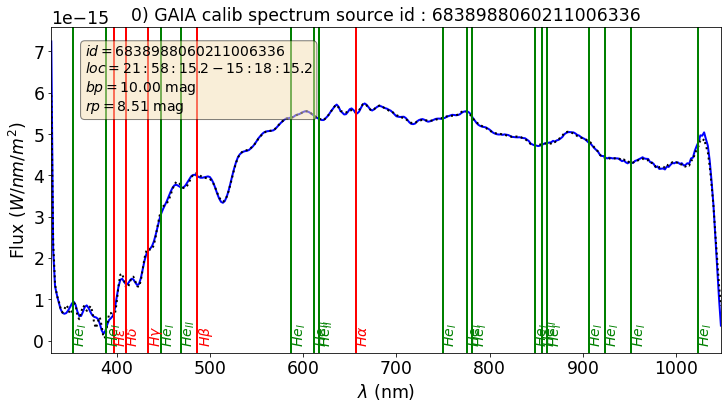

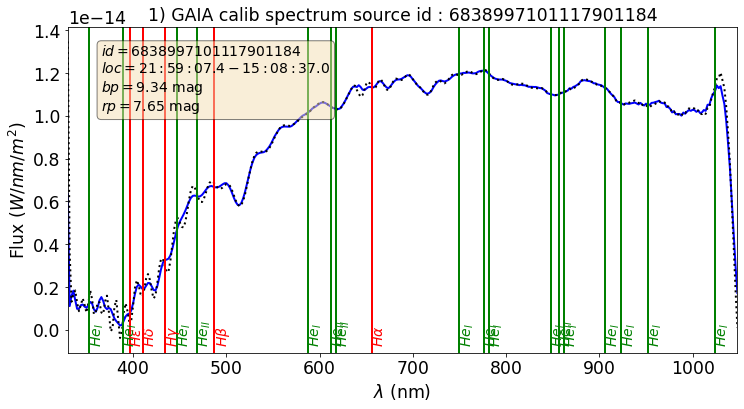

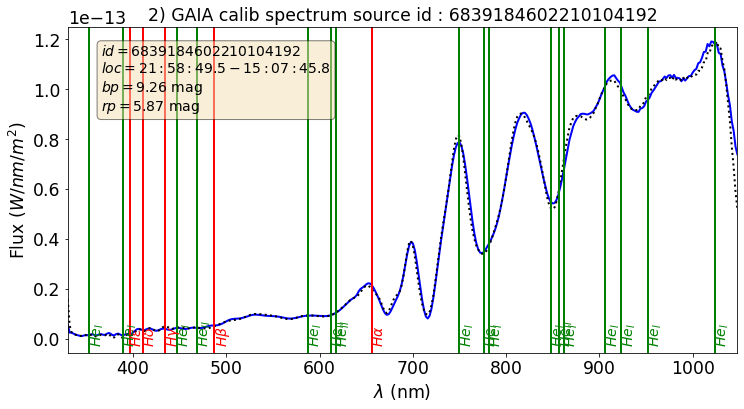

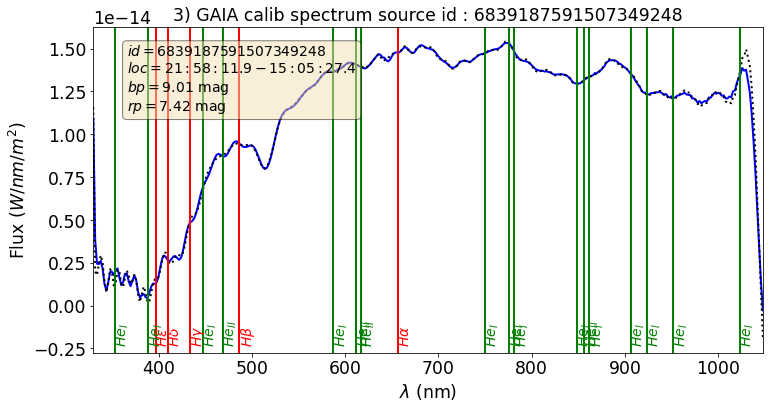

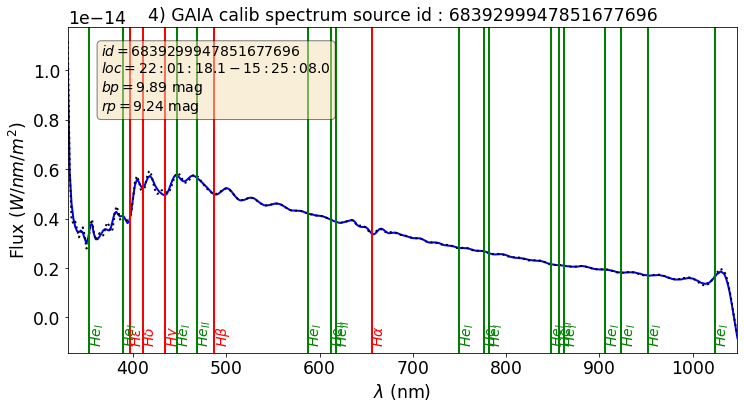

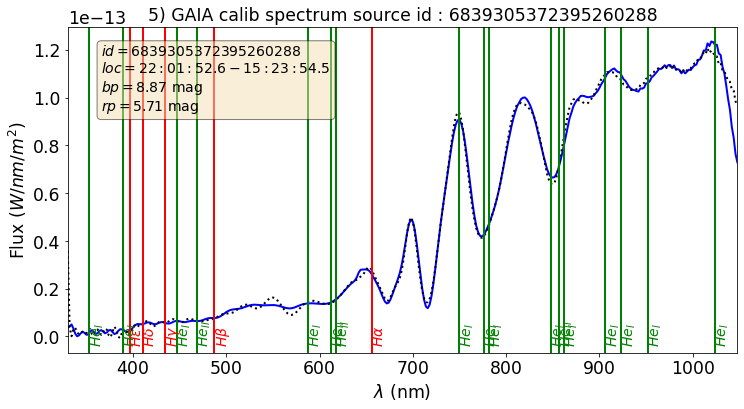

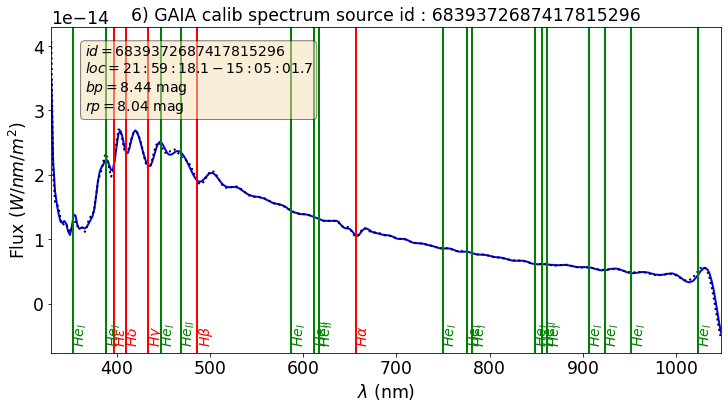

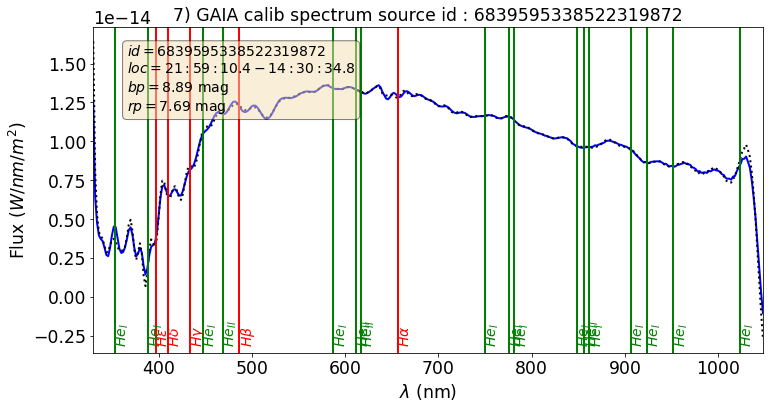

In [42]:
for idx in range(Nsources):
    plt.figure()
    plt.plot(sampling,calibrated_spectra_geom.iloc[idx]["flux"],'b-')
    plt.plot(sampling,calibrated_spectra_geom_nottrunk.iloc[idx]["flux"],'k:')
    ax = plt.gca()
    plot_lines(my_calib_hydrogenlines,ax,sampling.min(),sampling.max())
    plot_lines(my_calib_ismlines,ax,sampling.min(),sampling.max(),color="g")
    plt.xlim(sampling.min(),sampling.max())
    
    idn=results[idx]['source_id']
    bp=results[idx]['phot_bp_mean_mag']
    rp=results[idx]['phot_rp_mean_mag']
    loc=results[idx]['location']
    
    
    textstr = '\n'.join((
    r'$id=%.2d$' % (idn, ),
    r'$loc=%s$' % (loc, ),
    r'$bp=%.2f$ mag' % (bp, ),    
    r'$rp=%.2f$ mag' % (rp, )))
    
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    #plt.axvline(HALPHA.wavelength, lw=2, color="r")
    the_title=str(idx) +") GAIA calib spectrum source id : "+ str(calibrated_spectra_geom.iloc[idx]["source_id"])
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("Flux ($W/nm/m^2$)")
    plt.show()
    
   
    

In [43]:
all_aladin = []
for idx in range(Nsources):
    loc=results[idx]['location']
    aladin = Aladin(layout=Layout(width='50.0%'),survey='P/DSS2/color',target = loc ,fov = fov0/6, reticle_size= 64, reticle_color= '#ff89ff',grid=True)
    all_aladin.append(aladin)
    

In [44]:
all_aladin[0]

Aladin(fov=0.16666666666666666, layout=Layout(width='50.0%'), options=['allow_full_zoomout', 'coo_frame', 'fov…

In [45]:
all_aladin[1]

Aladin(fov=0.16666666666666666, layout=Layout(width='50.0%'), options=['allow_full_zoomout', 'coo_frame', 'fov…

In [46]:
all_aladin[2]

Aladin(fov=0.16666666666666666, layout=Layout(width='50.0%'), options=['allow_full_zoomout', 'coo_frame', 'fov…